# Table of Contents
 <p><div class="lev1 toc-item"><a href="#环境准备" data-toc-modified-id="环境准备-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>环境准备</a></div><div class="lev2 toc-item"><a href="#导入必须的库" data-toc-modified-id="导入必须的库-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>导入必须的库</a></div><div class="lev2 toc-item"><a href="#环境设置（按照实际情况修改）" data-toc-modified-id="环境设置（按照实际情况修改）-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>环境设置（按照实际情况修改）</a></div><div class="lev2 toc-item"><a href="#csv文件处理" data-toc-modified-id="csv文件处理-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>csv文件处理</a></div><div class="lev2 toc-item"><a href="#各种函数" data-toc-modified-id="各种函数-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>各种函数</a></div><div class="lev1 toc-item"><a href="#数据处理" data-toc-modified-id="数据处理-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>数据处理</a></div><div class="lev2 toc-item"><a href="#收集有结节的病患" data-toc-modified-id="收集有结节的病患-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>收集有结节的病患</a></div><div class="lev1 toc-item"><a href="#可视化" data-toc-modified-id="可视化-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>可视化</a></div><div class="lev2 toc-item"><a href="#定义一个画图的函数（抄的）" data-toc-modified-id="定义一个画图的函数（抄的）-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>定义一个画图的函数（抄的）</a></div><div class="lev2 toc-item"><a href="#随机挑选一个npy可视化" data-toc-modified-id="随机挑选一个npy可视化-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>随机挑选一个npy可视化</a></div>


# 环境准备


## 导入必须的库

In [2]:
import SimpleITK as sitk
import numpy as np
import os
import random
from glob import glob
import pandas as pd
import scipy.ndimage
from py import mhd_utils_3d
import matplotlib.pyplot as plt

%matplotlib inline

## 环境设置（按照实际情况修改）
- 主目录（本ipython文件所在目录）：‘./’
- 所有样本目录：'sample_patients/'
- 样本csv：'csv_files/annotations.csv'
- 自动新建存放npy的文件夹：'npy/'

In [2]:
luna_path = './'
luna_subset_path = luna_path + 'sample_patients/'
file_list = glob(luna_subset_path + "*.mhd")

df_node = pd.read_csv(luna_path + 'csv_files/' + 'annotations.csv')

if os.path.isdir('./npy'):
    pass
else:
    os.mkdir('./npy')

## csv文件处理

In [3]:
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return(f)

# map file full path to each record 
df_node['file'] = df_node['seriesuid'].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()
df_node.head(5)

,seriesuid,coordX,coordY,coordZ,diameter_mm,file
1002,1.3.6.1.4.1.14519.5.2.1.6279.6001.487268565754...,119.208776,11.450374,-165.039862,26.837081,./sample_patients/1.3.6.1.4.1.14519.5.2.1.6279...
1003,1.3.6.1.4.1.14519.5.2.1.6279.6001.487268565754...,-37.901617,55.027912,-80.002605,17.718729,./sample_patients/1.3.6.1.4.1.14519.5.2.1.6279...
1145,1.3.6.1.4.1.14519.5.2.1.6279.6001.910435939545...,68.243850,83.940751,-296.892458,7.068564,./sample_patients/1.3.6.1.4.1.14519.5.2.1.6279...
1146,1.3.6.1.4.1.14519.5.2.1.6279.6001.910435939545...,53.469331,86.958564,-244.223244,8.704938,./sample_patients/1.3.6.1.4.1.14519.5.2.1.6279...
1147,1.3.6.1.4.1.14519.5.2.1.6279.6001.910435939545...,-91.369924,-6.167830,-218.833869,6.162973,./sample_patients/1.3.6.1.4.1.14519.5.2.1.6279...


In [4]:
print '数据条数：'
print df_node.shape[0]

数据条数：
9


## 各种函数

In [5]:
#!/usr/bin/env python
#coding=utf-8

#======================================================================
#Program:   Diffusion Weighted MRI Reconstruction
#Link:      https://code.google.com/archive/p/diffusion-mri
#Module:    $RCSfile: mhd_utils.py,v $
#Language:  Python
#Author:    $Author: bjian $
#Date:      $Date: 2008/10/27 05:55:55 $
#Version:   
#           $Revision: 1.1 by PJackson 2013/06/06 $
#               Modification: Adapted to 3D
#               Link: https://sites.google.com/site/pjmedphys/tutorials/medical-images-in-python
# 
#           $Revision: 2   by RodenLuo 2017/03/12 $
#               Modication: Adapted to LUNA2016 data set for DSB2017
#               Link: 
#======================================================================

import os
import numpy
import array

## Define resample method to make images isomorphic, default spacing is [1, 1, 1]mm


def resample(image, old_spacing, new_spacing=[1, 1, 1]):
    
    resize_factor = old_spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = old_spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode = 'nearest')
    
    return image, new_spacing
def write_meta_header(filename, meta_dict):
    header = ''
    # do not use tags = meta_dict.keys() because the order of tags matters
    tags = ['ObjectType','NDims','BinaryData',
       'BinaryDataByteOrderMSB','CompressedData','CompressedDataSize',
       'TransformMatrix','Offset','CenterOfRotation',
       'AnatomicalOrientation',
       'ElementSpacing',
       'DimSize',
       'ElementType',
       'ElementDataFile',
       'Comment','SeriesDescription','AcquisitionDate','AcquisitionTime','StudyDate','StudyTime']
    for tag in tags:
        if tag in meta_dict.keys():
            header += '%s = %s\n'%(tag,meta_dict[tag])
    f = open(filename,'w')
    f.write(header)
    f.close()
    
def dump_raw_data(filename, data):
    """ Write the data into a raw format file. Big endian is always used. """
    #Begin 3D fix
    data=data.reshape([data.shape[0],data.shape[1]*data.shape[2]])
    #End 3D fix
    rawfile = open(filename,'wb')
    a = array.array('f')
    for o in data:
        a.fromlist(list(o))
    #if is_little_endian():
    #    a.byteswap()
    a.tofile(rawfile)
    rawfile.close()
    
def write_mhd_file(mhdfile, data, dsize):
    assert(mhdfile[-4:]=='.mhd')
    meta_dict = {}
    meta_dict['ObjectType'] = 'Image'
    meta_dict['BinaryData'] = 'True'
    meta_dict['BinaryDataByteOrderMSB'] = 'False'
    meta_dict['ElementType'] = 'MET_FLOAT'
    meta_dict['NDims'] = str(len(dsize))
    meta_dict['DimSize'] = ' '.join([str(i) for i in dsize])
    meta_dict['ElementDataFile'] = os.path.split(mhdfile)[1].replace('.mhd','.raw')
    write_meta_header(mhdfile, meta_dict)

    pwd = os.path.split(mhdfile)[0]
    if pwd:
        data_file = pwd +'/' + meta_dict['ElementDataFile']
    else:
        data_file = meta_dict['ElementDataFile']

    dump_raw_data(data_file, data)
    
def save_nodule(nodule_crop, name_index):
    np.save('./npy/' + str(name_index) + '.npy', nodule_crop)
    write_mhd_file('./npy/' + str(name_index) + '.mhd', nodule_crop, nodule_crop.shape[::-1])

# 数据处理

## 收集有结节的病患
- 修改第一行代码中的数字，确定处理多少条数据，如果只是做可视化，改为1，如果处理全部数据，删除1

In [6]:
#In this code snippet, the cropped nodule is a [19, 19, 19] volume with [1, 1, 1]mm spacing.
for patient in file_list[:1]:
    print(patient)
    
    # Check whether this patient has nodule or not
    if patient not in df_node.file.values:
        print('Patient ' + patient + 'Not exist!')
        continue
    patient_nodules = df_node[df_node.file == patient]
    
    full_image_info = sitk.ReadImage(patient)
    full_scan = sitk.GetArrayFromImage(full_image_info)
    
    origin = np.array(full_image_info.GetOrigin())[::-1] # get [z, y, x] origin
    old_spacing = np.array(full_image_info.GetSpacing())[::-1] # get [z, y, x] spacing
    
    image, new_spacing = resample(full_scan, old_spacing)
    
    print('Resample Done')
    

    for index, nodule in patient_nodules.iterrows():
        nodule_center = np.array([nodule.coordZ, nodule.coordY, nodule.coordX]) 
        # Attention: Z, Y, X

        v_center = np.rint( (nodule_center - origin) / new_spacing )
        v_center = np.array(v_center, dtype=int)

#         print(v_center)
        window_size = 9 # This will give you the volume length = 9 + 1 + 9 = 19
        # Why the magic number 19, I found that in "LUNA16/annotations.csv", 
        # the 95th percentile of the nodules' diameter is about 19.
        # This is kind of a hyperparameter, will affect your final score.
        # Change it if you want.
        zyx_1 = v_center - window_size # Attention: Z, Y, X
        zyx_2 = v_center + window_size + 1

#         print('Crop range: ')
#         print(zyx_1)
#         print(zyx_2)

        # This will give you a [19, 19, 19] volume
        img_crop = image[ zyx_1[0]:zyx_2[0], zyx_1[1]:zyx_2[1], zyx_1[2]:zyx_2[2] ]
        
        # save the nodule 
        save_nodule(img_crop, index)
    
    print('Done for this patient!\n\n')
print('Done for all!')

./sample_patients/1.3.6.1.4.1.14519.5.2.1.6279.6001.487268565754493433372433148666.mhd
Resample Done
Done for this patient!


Done for all!


# 可视化

## 定义一个画图的函数（抄的）

In [7]:
## Plot volume in 2D

import numpy as np
from matplotlib import pyplot as plt

def plot_nodule(nodule_crop):
    f, plots = plt.subplots(int(nodule_crop.shape[0]/4)+1, 4, figsize=(20, 20))    
    for z_ in range(nodule_crop.shape[0]): 
        plots[int(z_/4), z_ % 4].imshow(nodule_crop[z_,:,:])
    
    # The last subplot has no image because there are only 19 images.
    plt.show()

## 随机挑选一个npy可视化

./npy/1003.npy


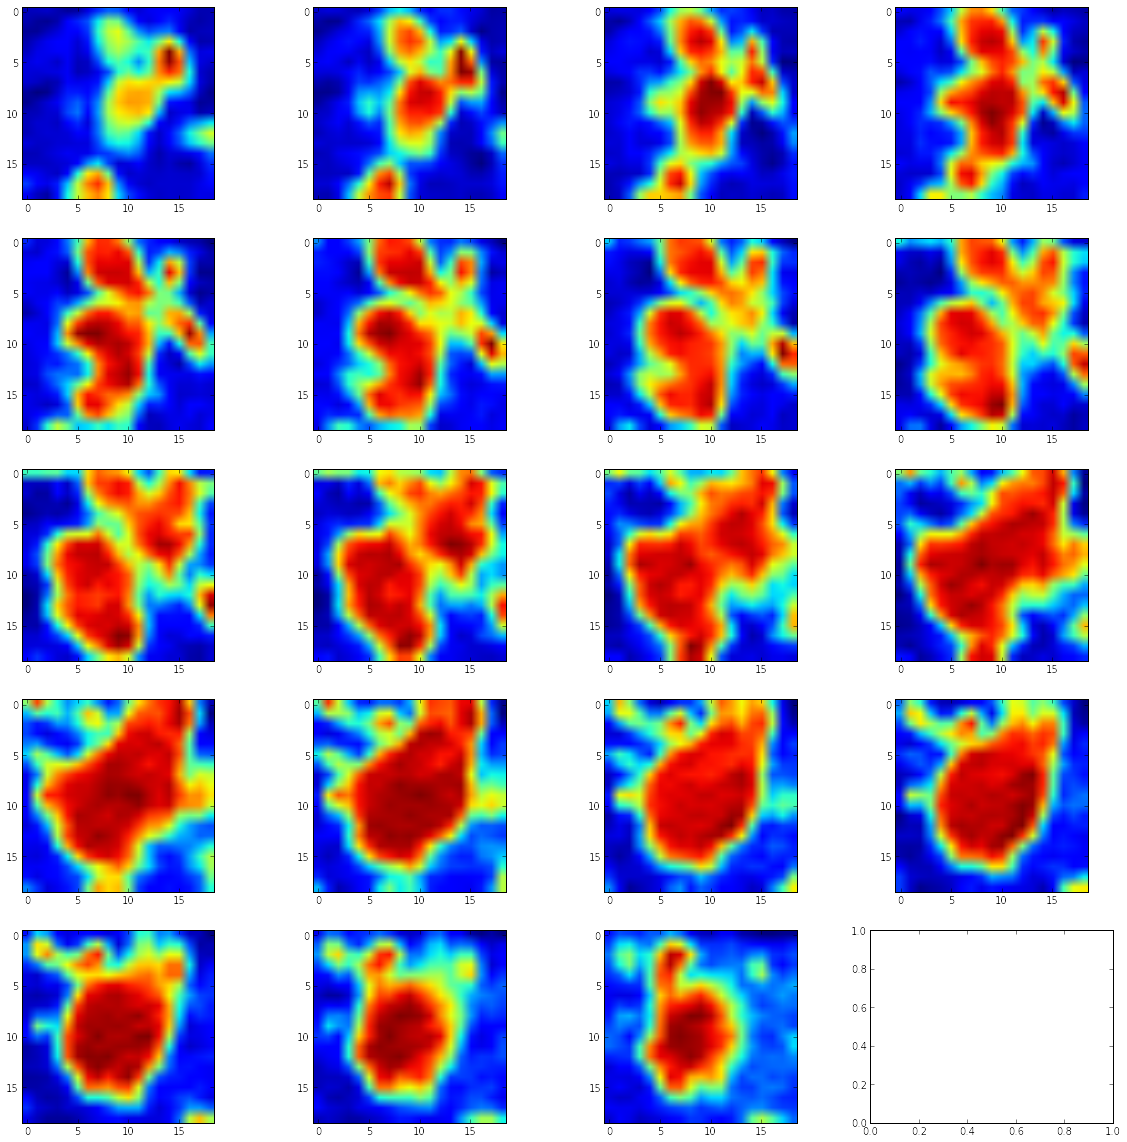

In [8]:
 all_sample = random.sample(glob(os.path.join('./npy/' + "*.npy")),1)[0]
# Plot one example
img_crop = np.load(all_sample)
print all_sample
plot_nodule(img_crop)